## Importing required libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score
from category_encoders import TargetEncoder

## Getting started with the dataset

In [2]:
# importing the dataset
df = pd.DataFrame(pd.read_csv('weatherHistory_regression.csv'))
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.


The "weatherHistory_regression.csv" dataset is a comprehensive collection of weather-related parameters, including date, precipitation type, temperature, humidity, wind speed, visibility, loud cover, pressure, and daily summary. It provides detailed weather information for each hour, making it useful for regression analysis and climate analysis. The dataset has 96453 rows and 12 columns.

### Removing duplications and missing values

In [3]:
df.isna().sum() # checking for missing values

Formatted Date                0
Summary                       0
Precip Type                 520
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             5
Wind Bearing (degrees)        0
Visibility (km)               8
Loud Cover                    0
Pressure (millibars)          7
Daily Summary                 0
dtype: int64

In [4]:
df.shape

(96450, 12)

In [5]:
# removing missing values and checking for duplicated values
df1=df.dropna()
df1.duplicated().sum()

24

In [6]:
# dropping the duplicated rows
df_drop=df1.drop_duplicates()
print("number of duplicates", df1.duplicated().sum())
print("number of unique rows", len(df_drop))

number of duplicates 24
number of unique rows 95886


### Checking the columns

In [7]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95886 entries, 0 to 96449
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            95886 non-null  object 
 1   Summary                   95886 non-null  object 
 2   Precip Type               95886 non-null  object 
 3   Temperature (C)           95886 non-null  float64
 4   Apparent Temperature (C)  95886 non-null  float64
 5   Humidity                  95886 non-null  float64
 6   Wind Speed (km/h)         95886 non-null  float64
 7   Wind Bearing (degrees)    95886 non-null  int64  
 8   Visibility (km)           95886 non-null  float64
 9   Loud Cover                95886 non-null  int64  
 10  Pressure (millibars)      95886 non-null  float64
 11  Daily Summary             95886 non-null  object 
dtypes: float64(6), int64(2), object(4)
memory usage: 9.5+ MB


In [8]:
df_drop.nunique()

Formatted Date              95886
Summary                        24
Precip Type                     4
Temperature (C)              7573
Apparent Temperature (C)     8984
Humidity                       90
Wind Speed (km/h)            2483
Wind Bearing (degrees)        360
Visibility (km)               949
Loud Cover                      1
Pressure (millibars)         4971
Daily Summary                 214
dtype: int64

we take 'summery' column as our target variable, since this is a catogarical column, first we have to identify the catogaries in it.

In [9]:
df_drop["Summary"].value_counts()

Summary
Partly Cloudy               31625
Mostly Cloudy               27907
Overcast                    16505
Clear                       10745
Foggy                        7116
Breezy and Overcast           528
Breezy and Mostly Cloudy      516
Breezy and Partly Cloudy      386
Dry and Partly Cloudy          86
Windy and Partly Cloudy        67
Light Rain                     63
Breezy                         54
Windy and Overcast             45
Humid and Mostly Cloudy        40
Drizzle                        39
Windy and Mostly Cloudy        35
Breezy and Foggy               35
Dry                            34
Humid and Partly Cloudy        17
Dry and Mostly Cloudy          14
Rain                           10
Windy                           8
Humid and Overcast              7
Windy and Foggy                 4
Name: count, dtype: int64

## Dealing with date/time data

in this dataset, there is a column that contains date/time values, which is "Formatted Date". it should be converted as suitable for the analysis. it should be converted into datetime object.

In [10]:
df3 = df_drop.copy() # taking a copy of df_drop

df3['Formatted Date'] = pd.to_datetime(df3['Formatted Date'], format='%Y-%m-%d %H:%M:%S.%f %z', utc=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95886 entries, 0 to 96449
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            95886 non-null  datetime64[ns, UTC]
 1   Summary                   95886 non-null  object             
 2   Precip Type               95886 non-null  object             
 3   Temperature (C)           95886 non-null  float64            
 4   Apparent Temperature (C)  95886 non-null  float64            
 5   Humidity                  95886 non-null  float64            
 6   Wind Speed (km/h)         95886 non-null  float64            
 7   Wind Bearing (degrees)    95886 non-null  int64              
 8   Visibility (km)           95886 non-null  float64            
 9   Loud Cover                95886 non-null  int64              
 10  Pressure (millibars)      95886 non-null  float64            
 11  Daily Summary       

In [11]:
# deviding 'Formatted Date' column into parts so it will help for the analysis

df3['year'] = df3['Formatted Date'].dt.year
df3['month'] = df3['Formatted Date'].dt.month
df3['day'] = df3['Formatted Date'].dt.day
df3['dow'] = df3['Formatted Date'].dt.dayofweek
df3['time'] = df3['Formatted Date'].dt.time
df3['hour'] = df3['Formatted Date'].dt.hour
df3['minute'] = df3['Formatted Date'].dt.minute
df3['second'] = df3['Formatted Date'].dt.second
df3.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,year,month,day,dow,time,hour,minute,second
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.,2006,3,31,4,22:00:00,22,0,0
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.,2006,3,31,4,23:00:00,23,0,0
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.,2006,4,1,5,00:00:00,0,0,0
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.,2006,4,1,5,01:00:00,1,0,0
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.,2006,4,1,5,02:00:00,2,0,0


## Dealing with unwanted columns

In [12]:
# checking the unique values that each column has
df3.nunique()

Formatted Date              95886
Summary                        24
Precip Type                     4
Temperature (C)              7573
Apparent Temperature (C)     8984
Humidity                       90
Wind Speed (km/h)            2483
Wind Bearing (degrees)        360
Visibility (km)               949
Loud Cover                      1
Pressure (millibars)         4971
Daily Summary                 214
year                           12
month                          12
day                            31
dow                             7
time                           24
hour                           24
minute                          1
second                          1
dtype: int64

since the 'Formatted Data' column has 95886 different values, we can drop it because it may not provide meaningful information to predict the target variable. and we already extracted meaningful componants from this column.

'Loude cover' column may not provide meaningful information since it contains only one catogary of values. And also we can ommit 'minute' and 'second' column for that reason.

'time' column gives only the hours of time, since there is an 'hour' column we can reduce 'time' column

In [13]:
df_drop = df3.drop(['Formatted Date', 'Loud Cover', 'minute', 'second', 'time'], axis=1)
df_drop.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day,dow,hour
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,Partly cloudy throughout the day.,2006,3,31,4,22
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,Partly cloudy throughout the day.,2006,3,31,4,23
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,Partly cloudy throughout the day.,2006,4,1,5,0
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,Partly cloudy throughout the day.,2006,4,1,5,1
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,Partly cloudy throughout the day.,2006,4,1,5,2


### Dealing with Precip Type column

in 'Precip Type' column, there are 4 different values

In [14]:
df_drop['Precip Type'].value_counts()

Precip Type
rain    85171
snow    10712
?           2
%           1
Name: count, dtype: int64

mainly, there are two different values, 'rain' and 'snow', quantity of other values are very little, so we can replace them with other two values, lets print those rows and take a look at them.

In [15]:
# Filter rows containing '?' or '%' in 'Precip Type' column
rows_with_missing_values = df_drop[df_drop['Precip Type'].isin(['?', '%'])]

# Display the filtered rows
rows_with_missing_values

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day,dow,hour
25082,Clear,?,4.338889,2.772222,0.92,6.6332,268,6.2951,1023.80,Partly cloudy starting in the afternoon contin...,2008,10,18,5,2
54691,Overcast,?,2.061111,-1.694444,0.90,14.0875,131,11.5920,1002.51,Mostly cloudy starting in the morning.,2012,12,4,1,20
75865,Overcast,%,7.177778,4.827778,0.86,12.5097,0,9.9820,1008.06,Overcast throughout the day.,2014,3,5,2,7


by looking at the temperature, we can add them to mode catogari which is 'rain'

In [16]:
mode_value = df_drop['Precip Type'].mode()

# replacing '?' and '%' values with mode value
df_drop.loc[df_drop['Precip Type'].isin(['?', '%']), 'Precip Type'] = mode_value
df_drop['Precip Type'].value_counts()

Precip Type
rain    85171
snow    10712
Name: count, dtype: int64

now we can assign binary values to these two values and make a different column from it, and then we remove precipe type column. we assign as,
<br>rain = 1
snow = 0

In [17]:
# converting to binary data
df4 = pd.get_dummies(df_drop['Precip Type'])

df5 = pd.concat((df_drop, df4), axis=1)
df5 = df5.drop(['Precip Type', 'snow'], axis=1)
df5_copy = df5.copy()
df5_copy['rain'] = df5_copy['rain'].astype(int)
df5 = df5_copy.rename(columns={'rain':'Precip Type (rain=1, snow=0)'})
df5.head()

,Summary,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,year,month,day,dow,hour,"Precip Type (rain=1, snow=0)"
0,Partly Cloudy,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,Partly cloudy throughout the day.,2006,3,31,4,22,1
1,Partly Cloudy,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,Partly cloudy throughout the day.,2006,3,31,4,23,1
2,Mostly Cloudy,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,Partly cloudy throughout the day.,2006,4,1,5,0,1
3,Partly Cloudy,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,Partly cloudy throughout the day.,2006,4,1,5,1,1
4,Mostly Cloudy,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,Partly cloudy throughout the day.,2006,4,1,5,2,1


### Dealing with daily summery column

In [18]:
print(df5['Daily Summary'].describe())
print("\n Value counts",df5['Daily Summary'].value_counts())

count                                 95886
unique                                  214
top       Mostly cloudy throughout the day.
freq                                  20013
Name: Daily Summary, dtype: object

 Value counts Daily Summary
Mostly cloudy throughout the day.         20013
Partly cloudy throughout the day.          9929
Partly cloudy until night.                 6169
Partly cloudy starting in the morning.     5177
Foggy in the morning.                      4201
                                          ...  
Rain until afternoon.                        17
Rain until morning.                          12
Light rain in the morning.                   11
Drizzle starting in the evening.              9
Light rain overnight.                         3
Name: count, Length: 214, dtype: int64


'Daily summary' column has 214 unique values, we should encode these values as binary data, it will consume more computational power. 

In [19]:
# Contingency table (cross-tabulation) of the two categorical variables
contingency_table = pd.crosstab(df5['Daily Summary'], df5['Summary'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)


Chi-square statistic: 322452.9494504286
P-value: 0.0
Degrees of freedom: 4899
Expected frequencies table:
[[0.01351605 0.0087604  0.12915337 ... 0.0087604  0.01126338 0.01676991]
 [0.01351605 0.0087604  0.12915337 ... 0.0087604  0.01126338 0.01676991]
 [0.01351605 0.0087604  0.12915337 ... 0.0087604  0.01126338 0.01676991]
 ...
 [0.00957387 0.00620529 0.09148364 ... 0.00620529 0.00797822 0.01187869]
 [0.00675803 0.0043802  0.06457668 ... 0.0043802  0.00563169 0.00838496]
 [0.01351605 0.0087604  0.12915337 ... 0.0087604  0.01126338 0.01676991]]


The chi square test shows that there are a significant relation between 'Daily Summary' and 'Summary' variables. due to computational complexity the 'Daily Summary' feature make, we decide to drop that column from our dataset.

In [20]:
df5_drop = df5.drop(['Daily Summary'], axis=1)
df5_drop.head()

,Summary,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),year,month,day,dow,hour,"Precip Type (rain=1, snow=0)"
0,Partly Cloudy,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,2006,3,31,4,22,1
1,Partly Cloudy,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,2006,3,31,4,23,1
2,Mostly Cloudy,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,2006,4,1,5,0,1
3,Partly Cloudy,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,2006,4,1,5,1,1
4,Mostly Cloudy,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,2006,4,1,5,2,1


In [21]:
non_numeric_columns = df5_drop.select_dtypes(exclude='number').columns
print(non_numeric_columns)
df5_drop.dtypes

Index(['Summary'], dtype='object')


Summary                          object
Temperature (C)                 float64
Apparent Temperature (C)        float64
Humidity                        float64
Wind Speed (km/h)               float64
Wind Bearing (degrees)            int64
Visibility (km)                 float64
Pressure (millibars)            float64
year                              int32
month                             int32
day                               int32
dow                               int32
hour                              int32
Precip Type (rain=1, snow=0)      int32
dtype: object

### creating correation matrix and heatmap

we can create a heatmap to study the relationships with feature variables, if the values are close to 1, there are significant relationship between those two variables and if it close to -1, the relationship is weak. if there are significantly related features in the table, it could lead to data overfitting. so, it is better to remove one of the two variables.

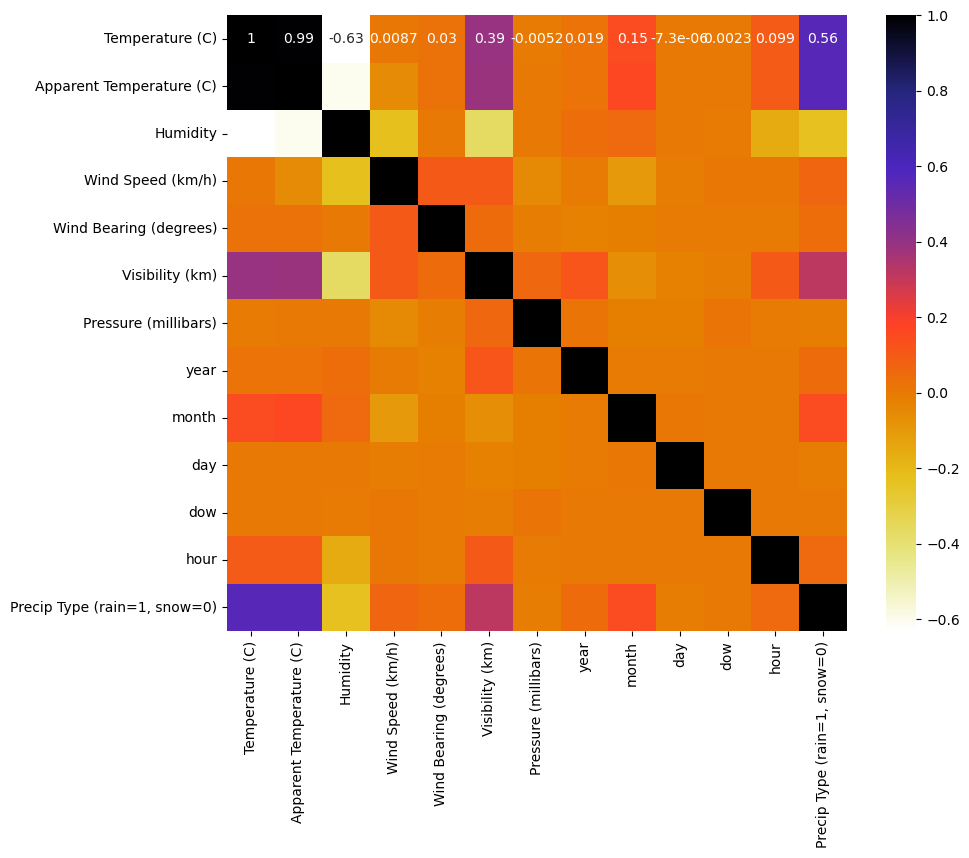

In [27]:
# to get feature variables only
dff = df5_drop.drop(['Summary'], axis=1)

plt.figure(figsize=(10, 8))
cor = dff.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

The study found a strong 0.99 correlation between two features in a dataset, 'Temperature' and 'Apparent Temperature', causing potential multicollinearity issues. To prevent this, one highly correlated feature was removed, enhancing model reliability and interpretability.

In [28]:
df6 = df5_drop.drop(['Apparent Temperature (C)'], axis=1)
df6.head()

,Summary,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),year,month,day,dow,hour,"Precip Type (rain=1, snow=0)"
0,Partly Cloudy,9.472222,0.89,14.1197,251,15.8263,1015.13,2006,3,31,4,22,1
1,Partly Cloudy,9.355556,0.86,14.2646,259,15.8263,1015.63,2006,3,31,4,23,1
2,Mostly Cloudy,9.377778,0.89,3.9284,204,14.9569,1015.94,2006,4,1,5,0,1
3,Partly Cloudy,8.288889,0.83,14.1036,269,15.8263,1016.41,2006,4,1,5,1,1
4,Mostly Cloudy,8.755556,0.83,11.0446,259,15.8263,1016.51,2006,4,1,5,2,1


## Random forest

### Hyperparmeter tuning

In [38]:
X = df6.drop(['Summary'], axis=1)
y = df6['Summary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

params = {
    "n_estimators":[100, 300, 500, 800, 1000, 1200, 1500, 2000],
    "criterion":['gini', 'entropy'],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4] 
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Grid = RandomizedSearchCV(estimator=RandomForestClassifier(class_weight="balanced"), 
                          param_distributions=params, 
                          cv=cv, 
                          scoring=scoring, 
                          n_iter=10, 
                          n_jobs=4,
                          verbose=2, 
                          pre_dispatch='2*n_jobs',
                          refit='accuracy')
Grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


D:\Anaconda\envs\tenenv\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
D:\Anaconda\envs\tenenv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
4 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\envs\tenenv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\envs\tenenv\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500, 800,
                                                         1000, 1200, 1500,
                                                         2000]},
                   refit='accuracy',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1': make_scorer(f1_score)},
                   verbose=2)

In [39]:
print(Grid.best_score_)
print(Grid.best_params_)

0.6984017640734989
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}


### Running the model

In [41]:
model = RandomForestClassifier(n_estimators=300, 
                               criterion='entropy', 
                               min_samples_split=5, 
                               max_depth=None, 
                               min_samples_leaf=1,
                               class_weight="balanced")
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

y_train_pred = model.predict(X_train)
score2 = accuracy_score(y_train, y_train_pred)

print("test accuracy: ", score)
print("train accuracy: ", score2)

test accuracy:  0.7112837626446971
train accuracy:  0.997457892266778


In [42]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute classification report
report = classification_report(y_test, y_pred, zero_division=0)
print("Classification Report:\n", report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Classification Report:
                           precision    recall  f1-score   support

                  Breezy       0.77      0.91      0.83        11
        Breezy and Foggy       0.78      1.00      0.88         7
Breezy and Mostly Cloudy       0.47      0.52      0.50       103
     Breezy and Overcast       0.62      0.77      0.69       106
Breezy and Partly Cloudy       0.51      0.65      0.57        77
                   Clear       0.72      0.60      0.65      2149
                 Drizzle       0.83      0.62      0.71         8
                     Dry       1.00      0.71      0.83         7
   Dry and Mostly Cloudy       0.00      0.00      0.00         3
   Dry and Partly Cloudy       0.55      0.35      0.43        17
                   Foggy       1.00      1.00      1.00      1423
 Humid and Mostly Cloudy       0.00      0.00      0.00         8
      Humid and Overcast       0.00      0.00      0.00         1
 Humid and Partly Cloudy       1.00      0.33      